In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime
import matplotlib.pyplot as plt
import numpy
from readSelfTrackerSheet import *
import difflib

In [3]:
sheet = RetrieveSpreadSheet()

In [4]:
 SetUpDates()

Please provide the begin date in "M/D/YYYY" format (ie 5/11/1989) to filter
	"all"	if you dont want to filter:all


In [5]:
GetListOfTraineeObjects(sheet)

Please indicate in semicolon seperated format who the desired trainees are.

	ie "Gamboa,Allan"; "Basior,Greg";...

	If all trainees are desired say:

	"all"

	Available Trainees are:

	Curnutt
	Rowlett
	Frye
	Helwig
	Griffin
	Garvey
	Pittman
	Perkins
	Warner
	Jestes
	Vaughan
all
Creating Object For curnutt
Creating Object For rowlett
Creating Object For frye
Creating Object For helwig
Creating Object For griffin
Creating Object For garvey
Creating Object For pittman
Creating Object For perkins
Creating Object For warner
Creating Object For jestes
Creating Object For vaughan


In [6]:
FilterTraineesDateRanges()

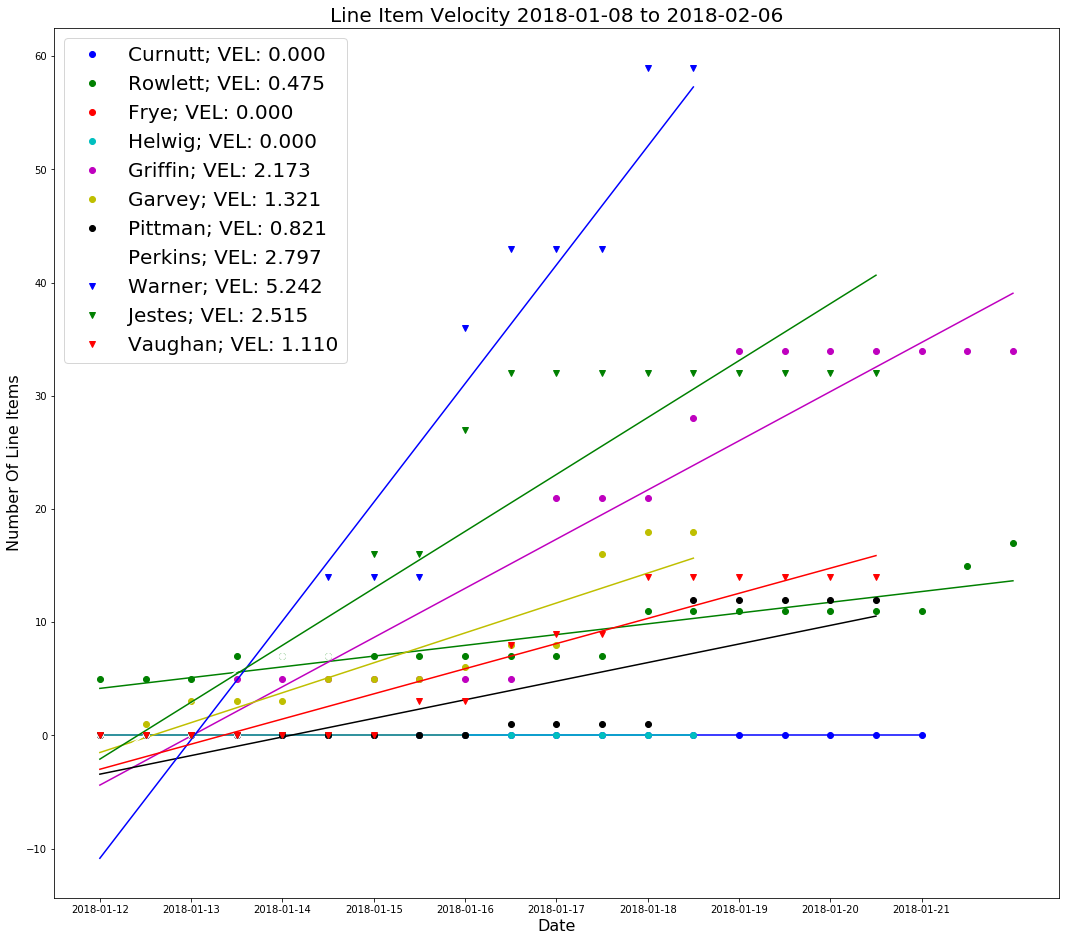

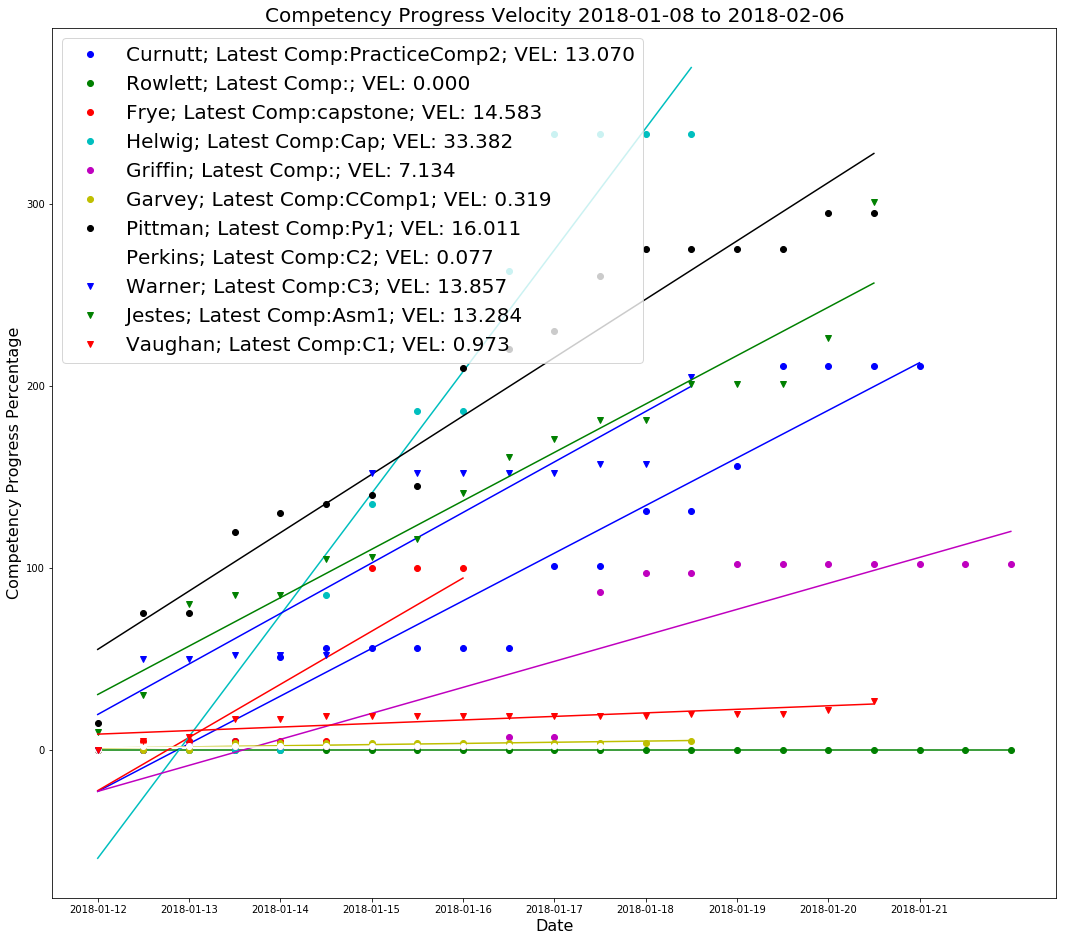

In [7]:
MakePlots()   

In [8]:
CreateTableOfVelocities()

2018-01-08 to 2018-02-06

Line Velocity ML:	Mean = 1.496	STD = 1.526
Comp Velocity ML:	Mean = 10.245	STD = 9.630
Line Velocity AVG:	Mean = 1.188	STD = 1.170
Comp Velocity AVG:	Mean = 9.181	STD = 7.926

      NAME          LINE ITEM       LINE ITEM     COMP PROGRESS   COMP PROGRESS    LINE ITEMS         COMPS     
                  VELOCITY ML    VELOCITY AVG    VELOCITYM ML    VELOCITY AVG      COMPLETED       COMPLETED   
    Curnutt          0.000           0.000           13.070          11.105            0               2       
    Rowlett          0.475           0.810           0.000           0.000            17               0       
     Frye            0.000           0.000           14.583          11.111            0               1       
    Helwig           0.000           0.000           33.382          24.143            0               0       
    Griffin          2.173           1.619           7.134           4.857            34               1       
    Garvey   

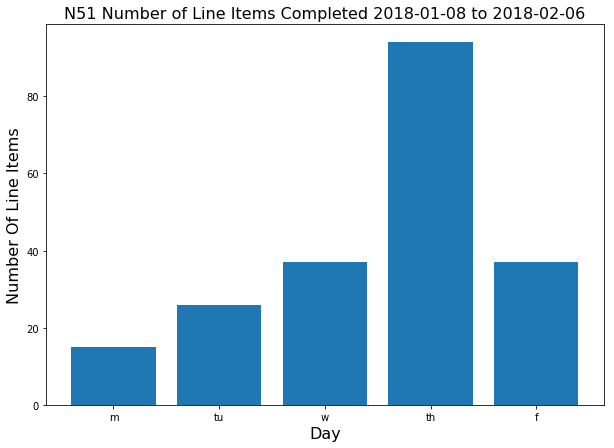

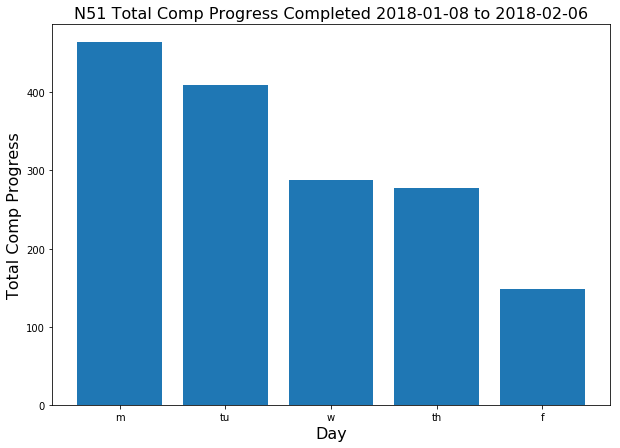

In [9]:
CreateDayOfWeekDistributions()

In [10]:
UpdateJQRTracker(selfTrackerSheetName='JQR Self Progress',
                     historicalTrackerSheetName='Historical Training Tracker',
                     targetSheetName='Training Tracker.xlsx')

Creating count object for  Curnutt.
PracticeComp1 is an invalid comp name.
PracticeComp2 is an invalid comp name.
Updating Curnutt.

Creating count object for  Rowlett.
Updating Rowlett.

Creating count object for  Frye.
Updating Frye.

Creating count object for  Helwig.
Updating Helwig.

Helwig has a new value (2) greater than max for Capstone 
Project (1). Contninue (y/n)?n
Creating count object for  Griffin.
Updating Griffin.

Creating count object for  Garvey.
Updating Garvey.

Creating count object for  Pittman.
Updating Pittman.

Creating count object for  Perkins.
Updating Perkins.

Creating count object for  Warner.
Could not find Warner in historical sheet.
Could not find Warner in historical sheet.
Updating Warner.

Creating count object for  Jestes.
Updating Jestes.

Creating count object for  Vaughan.
Updating Vaughan.



In [20]:
import numpy
numpy.mean([70, 90 , 87, 70])

79.25